# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Install Pacakges</div>

In [1]:
!pip install datasets lxml TinyImageNet matplotlib seaborn torch torchvision scipy scikit-learn safe_pfl_utils tabulate --quiet

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Import Libraries</div>

In [2]:
import copy as py_copy
import gc
import logging
import logging.config
import os
import os.path
import random
import sys
import tarfile
import warnings
from datetime import datetime
from heapq import nlargest
from itertools import combinations
from functools import partial
from math import sqrt
from typing import Callable, Optional
from torch.nn.utils import parameters_to_vector as Params2Vec
import torch.nn.utils.prune as prune
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from IPython.display import clear_output
from PIL import Image
from safe_pfl_utils.config import Config
from safe_pfl_utils.constants import (
    data_distribution_constants,
    datasets_constants,
    distances_constants,
    models_constants,
)
from scipy.stats import wasserstein_distance
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from tinyimagenet import TinyImageNet
from torch.autograd import Variable
from torch.utils.model_zoo import tqdm
from torchvision.datasets import (
    CIFAR10,
    CIFAR100,
    MNIST,
    STL10,
    SVHN,
    DatasetFolder,
    FashionMNIST,
    ImageFolder,
)
from torchvision.datasets.utils import check_integrity, download_file_from_google_drive
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import Normalize

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Configs</div>

In [3]:
DESIRED_DISTRIBUTION = [
    [2948, 0, 5293, 0, 0, 0, 0, 0, 0, 0],
    [1000, 0, 2330, 0, 0, 0, 0, 0, 0, 0],
    [1000, 0, 5292, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4249, 3729, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3729, 0, 2465, 0, 0, 0],
    [0, 0, 0, 3720, 0, 0, 2145, 0, 0, 0],
    [0, 0, 0, 0, 0, 3865, 2864, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1865, 2863, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5045, 3248],
    [0, 0, 0, 0, 0, 0, 0, 3465, 0, 1329],
]

""" 
    CNN-FMNIST configurations
"""
# configurations = Config(
#     MODEL_TYPE=models_constants.MODEL_CNN,
#     DATASET_TYPE=datasets_constants.DATA_SET_FMNIST,
#     DATA_DISTRIBUTION_KIND=data_distribution_constants.DATA_DISTRIBUTION_FIX,
#     DISTANCE_METRIC=distances_constants.DISTANCE_COORDINATE,
#     DESIRED_DISTRIBUTION=DESIRED_DISTRIBUTION,
#     CLUSTERING_PERIOD=5,  # 1, 10
#     FEDERATED_LEARNING_ROUNDS=35,
#     SAVE_BEFORE_AGGREGATION_MODELS=False,
#     SENSITIVITY_PERCENTAGE=100,  #! DO NOT CHANGE THIS VALUE WILL BE CALCULATE AUTOMATICALLY
#     NUMBER_OF_EPOCHS=1,
#     TRAIN_BATCH_SIZE=64,
#     TEST_BATCH_SIZE=64,
# )

configurations = Config(
    MODEL_TYPE=models_constants.MODEL_RESNET_18,
    DATASET_TYPE=datasets_constants.DATA_SET_SVHN,
    DATA_DISTRIBUTION_KIND=data_distribution_constants.DATA_DISTRIBUTION_FIX,
    DISTANCE_METRIC=distances_constants.DISTANCE_COORDINATE,
    DESIRED_DISTRIBUTION=DESIRED_DISTRIBUTION,
    CLUSTERING_PERIOD=2,  # 1, 10
    FEDERATED_LEARNING_ROUNDS=40,
    SAVE_BEFORE_AGGREGATION_MODELS=False,
    SENSITIVITY_PERCENTAGE=100,  #! DO NOT CHANGE THIS VALUE WILL BE CALCULATE AUTOMATICALLY
    NUMBER_OF_EPOCHS=1,
    TRAIN_BATCH_SIZE=128,
    TEST_BATCH_SIZE=128,
)

""" 
    ResNet18-SVHN configurations
"""
# configurations = Config(
#     MODEL_TYPE=models_constants.MODEL_RESNET_18,
#     DATASET_TYPE=datasets_constants.DATA_SET_SVHN,
#     DATA_DISTRIBUTION_KIND=data_distribution_constants.DATA_DISTRIBUTION_FIX,
#     DISTANCE_METRIC=distances_constants.DISTANCE_COORDINATE,
#     DESIRED_DISTRIBUTION=DESIRED_DISTRIBUTION,
#     CLUSTERING_PERIOD=2,
#     FEDERATED_LEARNING_ROUNDS=30, #! just run 24 FL round is enough for coordinate distance
#     SAVE_BEFORE_AGGREGATION_MODELS=True,
#     SENSITIVITY_PERCENTAGE=100, #! DO NOT CHANGE THIS VALUE WILL BE CALCULATE AUTOMATICALLY
#     NUMBER_OF_EPOCHS=1,
#     TRAIN_BATCH_SIZE=256,
#     TEST_BATCH_SIZE=256
# )

# """
#     ResNet50-CIFAR100 configurations
# """
# configurations = Config(
#     MODEL_TYPE=models_constants.MODEL_RESNET_50,
#     DATASET_TYPE=datasets_constants.DATA_SET_CIFAR_100,
#     DATA_DISTRIBUTION_KIND=data_distribution_constants.DATA_DISTRIBUTION_N_20,
#     DISTANCE_METRIC=distances_constants.DISTANCE_COORDINATE,
#     DESIRED_DISTRIBUTION=DESIRED_DISTRIBUTION,
#     CLUSTERING_PERIOD=5,
#     FEDERATED_LEARNING_ROUNDS=35, #! just run 24 FL round is enough for coordinate distance
#     SAVE_BEFORE_AGGREGATION_MODELS=True,
#     SENSITIVITY_PERCENTAGE=100, #! DO NOT CHANGE THIS VALUE WILL BE CALCULATE AUTOMATICALLY
#     NUMBER_OF_EPOCHS=1,
#     TRAIN_BATCH_SIZE=256,
#     TEST_BATCH_SIZE=256
# )

SAFE_PFL_CONFIG = configurations.get_config()

SAFE_PFL_CONFIG.update(
    {
        "DYNAMIC_SENSITIVITY_PERCENTAGE": True,
        "DISTANCE_METRIC_ON_PARAMETERS": True,
        "REMOVE_COMMON_IDS": False,
        "CLUSTER_AT_FIRST": False,
    }
)

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ["PL_GLOBAL_SEED"] = str(seed)

sns.set_theme(style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus": False})
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to produce reproducible results (like random.seed())
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False

In [5]:
class Log:
    def __init__(self):
        log_path = datetime.now().strftime(
            f'Model={SAFE_PFL_CONFIG["MODEL_TYPE"]}-Dataset={SAFE_PFL_CONFIG["DATASET_TYPE"]}-N={SAFE_PFL_CONFIG["PARTITION"]}-P={SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"]}_on={SAFE_PFL_CONFIG["DISTANCE_METRIC"]}_at=%Y-%m-%d_%H'
        )
        log_file = "logs/" + log_path + ".log"

        os.makedirs("logs", exist_ok=True)

        if os.path.exists(log_file):
            try:
                os.remove(log_file)
                print(f"Old log file '{log_file}' deleted.")
            except PermissionError as _:
                print(
                    "Log file deletion can cause data lost, if you are sure please restart you session"
                )

        self.log_instance = logging.getLogger("SAFE_PFL_LOGGER")
        self.log_instance.setLevel(logging.DEBUG)
        self.log_instance.propagate = False

        formatter = logging.Formatter(
            fmt="%(asctime)s, line: %(lineno)d %(levelname)8s | %(message)s",
            datefmt="%Y/%m/%d %H:%M:%S",
        )

        # Create a file handler
        file_handler = logging.FileHandler(log_file, mode="a")
        file_handler.setFormatter(formatter)
        self.log_instance.addHandler(file_handler)

        # Create a stream handler (for console output)
        screen_handler = logging.StreamHandler(stream=sys.stdout)
        screen_handler.setFormatter(formatter)
        self.log_instance.addHandler(screen_handler)

        self.log_instance.info("Logger object created successfully...")
        self.log_instance.warning(f"The {log_file} will be truncated at each run")

    def info(self, info: str):
        self.log_instance.info(info)
        self.flush()

    def warn(self, warn: str):
        self.log_instance.warning(warn)
        self.flush()

    def debug(self, debug: str):
        self.log_instance.debug(debug)
        self.flush()

    def critical(self, critical: str):
        self.log_instance.critical(critical)
        self.flush()

    def error(self, error: str):
        self.log_instance.error(error)
        self.flush()

    def flush(self):
        for handler in self.log_instance.handlers:
            if hasattr(handler, "flush"):
                handler.flush()

    def close(self):
        self.log_instance.handlers.close()

In [6]:
log = Log()

Old log file 'logs/Model=resnet18-Dataset=svhn-N=noniid-fix-P=100_on=coordinate_at=2025-02-09_07.log' deleted.
2025/02/09 07:38:00, line: 38     INFO | Logger object created successfully...
2025/02/09 07:38:00, line: 39  WARNING | The logs/Model=resnet18-Dataset=svhn-N=noniid-fix-P=100_on=coordinate_at=2025-02-09_07.log will be truncated at each run


In [7]:
table_data = [[key, value] for key, value in SAFE_PFL_CONFIG.items()]
log.info(tabulate(table_data, headers=["Config Key", "Value"], tablefmt="grid"))

2025/02/09 07:38:00, line: 42     INFO | +--------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Config Key                     | Value                                                                                                                                                                                                                                                                                                                                                                                        |
+================================+=========================================================================================

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Garbage Collection</div>

In [8]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def print_gpu_memory():
    log.info(f"Allocated memory: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
    log.info(f"Cached memory: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")


log.info("before memory cleaning")
print_gpu_memory()

gc.collect()
torch.cuda.empty_cache()

# cuda.select_device(0)
# cuda.close()

log.info("after memory cleaning")
print_gpu_memory()

# ----------- manually clear memory in case of any error
#!sudo fuser -v /dev/nvidia* or nvidia-smi
# remove all python process ids from gpu
#!sudo kill -9 PID.

# * Make directories
MODEL_SAVING_PATH = (
    os.path.join(
        "./models", SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["DATASET_TYPE"]
    )
    + "/"
)
if not os.path.exists(MODEL_SAVING_PATH):
    os.makedirs(MODEL_SAVING_PATH)

2025/02/09 07:38:00, line: 42     INFO | before memory cleaning
2025/02/09 07:38:00, line: 42     INFO | Allocated memory: 0.00 MB
2025/02/09 07:38:00, line: 42     INFO | Cached memory: 0.00 MB
2025/02/09 07:38:00, line: 42     INFO | after memory cleaning
2025/02/09 07:38:00, line: 42     INFO | Allocated memory: 0.00 MB
2025/02/09 07:38:00, line: 42     INFO | Cached memory: 0.00 MB


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Model Network</div>

In [9]:
class Net(nn.Module):
    def __init__(self, _model_type: str, _number_of_classes: int):
        super(Net, self).__init__()

        self._model_type = _model_type
        self._number_of_classes = _number_of_classes
        self.final_layer_name = None

        if self._model_type == "resnet18":
            self.resnet = models.resnet18(pretrained=False)
            # self.resnet.fc = nn.Linear(
            #     self.resnet.fc.in_features, self._number_of_classes
            # )
            self.resnet.fc = nn.Sequential(
            # Optional: you could add layers like dropout here.
            nn.Linear(512, self._number_of_classes)
        )
            self.final_layer_name = "resnet.fc.weight"
        elif self._model_type == "resnet50":
            self.resnet = models.resnet50(pretrained=False)
            self.resnet.fc = nn.Linear(
                self.resnet.fc.in_features, self._number_of_classes
            )
            self.final_layer_name = "resnet.fc.weight"
        elif self._model_type == "cnn":
            self.conv1 = nn.Conv2d(
                1, 32, kernel_size=3, stride=1, padding=1
            )  # Input: 1x28x28, Output: 32x28x28
            self.conv2 = nn.Conv2d(
                32, 64, kernel_size=3, stride=1, padding=1
            )  # Input: 32x28x28, Output: 64x28x28
            # Max pooling layer
            self.pool = nn.MaxPool2d(
                kernel_size=2, stride=2, padding=0
            )  # Reduces spatial dimensions by half
            # Fully connected layers
            self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input: 64x7x7, Output: 128
            self.fc2 = nn.Linear(128, self._number_of_classes)
            self.final_layer_name = "fc2.weight"
        elif self._model_type == "mobilenet":
            self.mobilenet = models.mobilenet_v2(pretrained=False)
            self.mobilenet.classifier[3] = nn.Linear(
                self.mobilenet.classifier[3].in_features, self._number_of_classes
            )
            self.final_layer_name = "mobilenet.classifier.3.weight"
        elif self._model_type == "alexnet":
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            self._to_linear = 128 * (128 // 8) * (128 // 8)
            self.classifier = nn.Sequential(
                nn.Linear(self._to_linear, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, self._number_of_classes),
            )
            self.final_layer_name = "classifier.3.weight"

    def forward(self, x):
        out = None

        if self._model_type in ["resnet18", "resnet50"]:
            out = self.resnet(x)
        elif self._model_type == "cnn":
            x = F.relu(self.conv1(x))  # Output: 32x28x28
            x = self.pool(x)  # Output: 32x14x14
            x = F.relu(self.conv2(x))  # Output: 64x14x14
            x = self.pool(x)  # Output: 64x7x7
            # Flatten the output for fully connected layers
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*7*7)
            # Fully connected layers
            x = F.relu(self.fc1(x))  # Output: 128
            x = self.fc2(x)  # Output: num_classes
            return x
        elif self._model_type == "mobilenet":
            out = self.mobilenet(x)

        elif self._model_type == "alexnet":
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            out = x
        return out

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Loading & Saving</div>

In [10]:
def load_torch_model(node_id):
    model_path = f"models/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def load_torch_model_before_agg(node_id):
    model_path = f"models/before_aggregation/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def save_torch_model_before_agg(model, client_id: str):
    model_path = f"models/before_aggregation/node_{client_id}.pth"
    torch.save(model, model_path)


def save_torch_model(model, node_id):
    model_path = f"models/node_{node_id}.pth"
    torch.save(model, model_path)


def save_model_param(model, node_id, round_number):
    model_path = f"models/node_{node_id}_round_{round_number}.pth"
    torch.save(model.state_dict(), model_path)

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Non-IID Distribution</div>

In [11]:
IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)


def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


class CustomTensorDataset(data.TensorDataset):
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors) + (index,)


class MNIST_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = MNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class FashionMNIST_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = FashionMNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class SVHN_custom(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        if self.train is True:

            svhn_dataobj = SVHN(
                self.root, "train", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels
        else:
            svhn_dataobj = SVHN(
                self.root, "test", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]
        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


# torchvision CelebA
class CelebA_custom(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        (
            "0B7EVK8r0v71pZjFTYXZWM3FlRnM",
            "00d2c5bc6d35e252742224ab0c1e8fcb",
            "img_align_celeba.zip",
        ),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        (
            "0B7EVK8r0v71pblRyaVFSWGxPY0U",
            "75e246fa4810816ffd6ee81facbd244c",
            "list_attr_celeba.txt",
        ),
        (
            "1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS",
            "32bd1bd63d3c78cd57e08160ec5ed1e2",
            "identity_CelebA.txt",
        ),
        (
            "0B7EVK8r0v71pbThiMVRxWXZ4dU0",
            "00566efa6fedff7a56946cd1c10f1c16",
            "list_bbox_celeba.txt",
        ),
        (
            "0B7EVK8r0v71pd0FJY3Blby1HUTQ",
            "cc24ecafdb5b50baae59b03474781f8c",
            "list_landmarks_align_celeba.txt",
        ),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        (
            "0B7EVK8r0v71pY0NSMzRuSXJEVkk",
            "d32c9cbf5e040fd4025c592c306e6668",
            "list_eval_partition.txt",
        ),
    ]

    def __init__(
        self,
        root,
        dataidxs=None,
        split="train",
        target_type="attr",
        transform=None,
        target_transform=None,
        download=False,
    ):
        import pandas

        super(CelebA_custom, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.split = split
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError("target_transform is specified but target_type is empty")

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted."
                + " You can use download=True to download it"
            )

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[split.lower()]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(
            fn("list_eval_partition.txt"),
            delim_whitespace=True,
            header=None,
            index_col=0,
        )
        identity = pandas.read_csv(
            fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0
        )
        bbox = pandas.read_csv(
            fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0
        )
        landmarks_align = pandas.read_csv(
            fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1
        )
        attr = pandas.read_csv(
            fn("list_attr_celeba.txt"), delim_whitespace=True, header=1
        )

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)
        self.gender_index = self.attr_names.index("Male")
        self.dataidxs = dataidxs
        if self.dataidxs is None:
            self.target = self.attr[
                :, self.gender_index : self.gender_index + 1
            ].reshape(-1)
        else:
            self.target = self.attr[
                self.dataidxs, self.gender_index : self.gender_index + 1
            ].reshape(-1)

    def _check_integrity(self):
        for _, md5, filename in self.file_list:
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False

        # Should check a hash of the images
        return os.path.isdir(
            os.path.join(self.root, self.base_folder, "img_align_celeba")
        )

    def download(self):
        import zipfile

        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        for file_id, md5, filename in self.file_list:
            download_file_from_google_drive(
                file_id, os.path.join(self.root, self.base_folder), filename, md5
            )

        with zipfile.ZipFile(
            os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r"
        ) as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        if self.dataidxs is None:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[index],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[index, self.gender_index])
                elif t == "identity":
                    target.append(self.identity[index, 0])
                elif t == "bbox":
                    target.append(self.bbox[index, :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[index, :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))
        else:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[self.dataidxs[index]],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[self.dataidxs[index], self.gender_index])
                elif t == "identity":
                    target.append(self.identity[self.dataidxs[index], 0])
                elif t == "bbox":
                    target.append(self.bbox[self.dataidxs[index], :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[self.dataidxs[index], :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))

        if self.transform is not None:
            X = self.transform(X)
        # print("target[0]:", target[0])
        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None
        # print("celeba target:", target)
        return X, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.attr)
        else:
            return len(self.dataidxs)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)


class STL10_truncated(data.Dataset):
    def __init__(
        self,
        root,
        dataidxs=None,
        split="train",
        transform=None,
        target_transform=None,
        download=False,
    ):
        """
        Custom STL10 dataset with support for data indexing.
        Args:
            root (str): Dataset root directory.
            dataidxs (list, optional): Indices for data partitioning. Defaults to None.
            split (str, optional): Dataset split ('train', 'test', 'unlabeled'). Defaults to 'train'.
            transform (callable, optional): Transformations for the input data. Defaults to None.
            target_transform (callable, optional): Transformations for the target labels. Defaults to None.
            download (bool, optional): Whether to download the dataset. Defaults to False.
        """
        self.root = root
        self.dataidxs = dataidxs
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.download = download
        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        stl10_dataobj = STL10(
            self.root,
            split=self.split,
            transform=self.transform,
            target_transform=self.target_transform,
            download=self.download,
        )
        data = stl10_dataobj.data
        target = np.array(stl10_dataobj.labels)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the class index.
        """
        img, target = self.data[index], self.target[index]

        # Ensure the image has the correct shape and dtype for PIL
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = img.astype(np.uint8)  # Ensure dtype is uint8 for PIL compatibility
        img = Image.fromarray(img)  # Convert to PIL Image

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class CIFAR10_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = cifar_dataobj.data
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            if isinstance(self.dataidxs, (list, np.ndarray, tuple)):
                self.dataidxs = np.array(self.dataidxs, dtype=np.int64)
                data = data[self.dataidxs]
                target = target[self.dataidxs]
            else:
                raise TypeError("dataidxs must be a list, numpy array, or None.")

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


def gen_bar_updater() -> Callable[[int, int, int], None]:
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update


def download_url(
    url: str, root: str, filename: Optional[str] = None, md5: Optional[str] = None
) -> None:
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    # check if file is already present locally
    if check_integrity(fpath, md5):
        print("Using downloaded and verified file: " + fpath)
    else:  # download the file
        try:
            print("Downloading " + url + " to " + fpath)
            urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
        except (urllib.error.URLError, IOError) as e:  # type: ignore[attr-defined]
            if url[:5] == "https":
                url = url.replace("https:", "http:")
                print(
                    "Failed download. Trying https -> http instead."
                    " Downloading " + url + " to " + fpath
                )
                urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
            else:
                raise e
        # check integrity of downloaded file
        if not check_integrity(fpath, md5):
            raise RuntimeError("File not found or corrupted.")


def _is_tarxz(filename: str) -> bool:
    return filename.endswith(".tar.xz")


def _is_tar(filename: str) -> bool:
    return filename.endswith(".tar")


def _is_targz(filename: str) -> bool:
    return filename.endswith(".tar.gz")


def _is_tgz(filename: str) -> bool:
    return filename.endswith(".tgz")


def _is_gzip(filename: str) -> bool:
    return filename.endswith(".gz") and not filename.endswith(".tar.gz")


def _is_zip(filename: str) -> bool:
    return filename.endswith(".zip")


def extract_archive(
    from_path: str, to_path: Optional[str] = None, remove_finished: bool = False
) -> None:
    if to_path is None:
        to_path = os.path.dirname(from_path)

    if _is_tar(from_path):
        with tarfile.open(from_path, "r") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, "r:gz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, "r:xz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(
            to_path, os.path.splitext(os.path.basename(from_path))[0]
        )
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, "r") as z:
            z.extractall(to_path)
    else:
        raise ValueError("Extraction of {} not supported".format(from_path))

    if remove_finished:
        os.remove(from_path)


def download_and_extract_archive(
    url: str,
    download_root: str,
    extract_root: Optional[str] = None,
    filename: Optional[str] = None,
    md5: Optional[str] = None,
    remove_finished: bool = False,
) -> None:
    download_root = os.path.expanduser(download_root)
    if extract_root is None:
        extract_root = download_root
    if not filename:
        filename = os.path.basename(url)

    download_url(url, download_root, filename, md5)

    archive = os.path.join(download_root, filename)
    print("Extracting {} to {}".format(archive, extract_root))
    extract_archive(archive, extract_root, remove_finished)


class FEMNIST(MNIST):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    resources = [
        (
            "https://raw.githubusercontent.com/tao-shen/FEMNIST_pytorch/master/femnist.tar.gz",
            "59c65cec646fc57fe92d27d83afdf0ed",
        )
    ]

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found." + " You can use download=True to download it"
            )
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        self.data, self.targets, self.users_index = torch.load(
            os.path.join(self.processed_folder, data_file)
        )

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode="F")
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def download(self):
        """Download the FEMNIST data if it doesn't exist in processed_folder already."""
        import shutil

        if self._check_exists():
            return

        mkdirs(self.raw_folder)
        mkdirs(self.processed_folder)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition("/")[2]
            download_and_extract_archive(
                url, download_root=self.raw_folder, filename=filename, md5=md5
            )

        # process and save as torch files
        print("Processing...")
        shutil.move(
            os.path.join(self.raw_folder, self.training_file), self.processed_folder
        )
        shutil.move(
            os.path.join(self.raw_folder, self.test_file), self.processed_folder
        )

    def __len__(self):
        return len(self.data)

    def _check_exists(self) -> bool:
        return all(
            check_integrity(
                os.path.join(
                    self.raw_folder,
                    os.path.splitext(os.path.basename(url))[0]
                    + os.path.splitext(os.path.basename(url))[1],
                )
            )
            for url, _ in self.resources
        )


class Generated(MNIST):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if self.train:
            self.data = np.load("data/generated/X_train.npy")
            self.targets = np.load("data/generated/y_train.npy")
        else:
            self.data = np.load("data/generated/X_test.npy")
            self.targets = np.load("data/generated/y_test.npy")

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class genData(MNIST):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class CIFAR100_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR100(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        if torchvision.__version__ == "0.2.1":
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(
                    cifar_dataobj.train_labels
                )
            else:
                data, target = cifar_dataobj.test_data, np.array(
                    cifar_dataobj.test_labels
                )
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class ImageFolder_custom(DatasetFolder):
    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=None,
    ):
        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        imagefolder_obj = ImageFolder(self.root, self.transform, self.target_transform)
        self.loader = imagefolder_obj.loader
        if self.dataidxs is not None:
            self.samples = np.array(imagefolder_obj.samples)[self.dataidxs]
        else:
            self.samples = np.array(imagefolder_obj.samples)

    def __getitem__(self, index):
        path = self.samples[index][0]
        target = self.samples[index][1]
        target = int(target)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.samples)
        else:
            return len(self.dataidxs)

In [12]:
def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def load_mnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = MNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = MNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_fmnist_data(datadir):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    mnist_train_ds = FashionMNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = FashionMNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_svhn_data(datadir):
    transform = transforms.Compose(
        [
            transforms.Resize(
                (
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                )
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )
    svhn_train_ds = SVHN_custom(datadir, train=True, download=True, transform=transform)
    svhn_test_ds = SVHN_custom(datadir, train=False, download=True, transform=transform)
    X_train, y_train = svhn_train_ds.data, svhn_train_ds.target
    X_test, y_test = svhn_test_ds.data, svhn_test_ds.target
    # X_train = X_train.data.numpy()
    # y_train = y_train.data.numpy()
    # X_test = X_test.data.numpy()
    # y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_cifar10_data(datadir):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    cifar10_train_ds = CIFAR10_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar10_test_ds = CIFAR10_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    return (X_train, y_train, X_test, y_test)


def load_celeba_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    celeba_train_ds = CelebA_custom(
        datadir, split="train", target_type="attr", download=True, transform=transform
    )
    celeba_test_ds = CelebA_custom(
        datadir, split="test", target_type="attr", download=True, transform=transform
    )
    gender_index = celeba_train_ds.attr_names.index("Male")
    y_train = celeba_train_ds.attr[:, gender_index : gender_index + 1].reshape(-1)
    y_test = celeba_test_ds.attr[:, gender_index : gender_index + 1].reshape(-1)
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (None, y_train, None, y_test)


def load_femnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = FEMNIST(datadir, train=True, transform=transform, download=True)
    mnist_test_ds = FEMNIST(datadir, train=False, transform=transform, download=True)
    X_train, y_train, u_train = (
        mnist_train_ds.data,
        mnist_train_ds.targets,
        mnist_train_ds.users_index,
    )
    X_test, y_test, u_test = (
        mnist_test_ds.data,
        mnist_test_ds.targets,
        mnist_test_ds.users_index,
    )
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    u_train = np.array(u_train)
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    u_test = np.array(u_test)
    return (X_train, y_train, u_train, X_test, y_test, u_test)


def load_cifar100_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    cifar100_train_ds = CIFAR100_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar100_test_ds = CIFAR100_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar100_train_ds.data, cifar100_train_ds.target
    X_test, y_test = cifar100_test_ds.data, cifar100_test_ds.target
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (X_train, y_train, X_test, y_test)


def load_tinyimagenet_data(datadir):
    split = "val"
    TinyImageNet(datadir, split=split)
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(64, padding=4),  # Random cropping with padding
            transforms.RandomHorizontalFlip(),  # Horizontal flip
            transforms.RandomRotation(15),  # Random rotation
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),  # Color jitter
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]
            ),  # Normalization
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]
            ),
        ]
    )
    # transform = transforms.Compose([transforms.ToTensor()])
    xray_train_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/train/", transform=transform_train
    )
    xray_test_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/val/", transform=transform_test
    )
    X_train, y_train = np.array([s[0] for s in xray_train_ds.samples]), np.array(
        [int(s[1]) for s in xray_train_ds.samples]
    )
    X_test, y_test = np.array([s[0] for s in xray_test_ds.samples]), np.array(
        [int(s[1]) for s in xray_test_ds.samples]
    )
    return (X_train, y_train, X_test, y_test)


def load_stl10_data(datadir):
    transform_train = transforms.Compose(
        [
            transforms.Resize(
                (
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                )
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )
    transform_test = transforms.Compose(
        [
            transforms.Resize(
                (
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                    SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                )
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )

    stl10_train_ds = STL10_truncated(
        datadir, split="train", transform=transform_train, download=True
    )
    stl10_test_ds = STL10_truncated(
        datadir, split="test", transform=transform_test, download=True
    )

    X_train, y_train = stl10_train_ds.data, stl10_train_ds.target
    X_test, y_test = stl10_test_ds.data, stl10_test_ds.target

    return X_train, y_train, X_test, y_test


def record_net_data_stats(y_train, net_dataidx_map, logdir):
    net_cls_counts = {}
    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp
    log.info("Data statistics: %s" % str(net_cls_counts))
    return net_cls_counts

In [13]:
def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.1):
    test_dataidx_map = {}

    # Load dataset
    if dataset == "mnist":
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == "fmnist":
        X_train, y_train, X_test, y_test = load_fmnist_data(datadir)
    elif dataset == "cifar10":
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == "svhn":
        X_train, y_train, X_test, y_test = load_svhn_data(datadir)
    elif dataset == "celeba":
        X_train, y_train, X_test, y_test = load_celeba_data(datadir)
    elif dataset == "femnist":
        X_train, y_train, u_train, X_test, y_test, u_test = load_femnist_data(datadir)
    elif dataset == "cifar100":
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == "tinyimagenet":
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)
    elif dataset == "stl10":
        X_train, y_train, X_test, y_test = load_stl10_data(datadir)
    elif dataset == "generated":
        # Code for generated dataset (omitted for brevity)
        pass
    # Add other datasets if needed

    n_train = y_train.shape[0]
    n_test = y_test.shape[0]
    
    # Partition the data
    if partition == "homo":
        # Homogeneous data partition
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}

    elif partition == "noniid-labeldir":
        min_size = 0
        min_require_size = 10  # Minimum number required for each party
        if dataset == "cifar100":
            K = 100  # Number of classes
        else:
            k = 10

        N = y_train.shape[0]
        net_dataidx_map = {}
        test_dataidx_map = {}  # Make sure to initialize this

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                proportions = np.array(
                    [
                        p * (len(idx_j) < N / n_parties)
                        for p, idx_j in zip(proportions, idx_batch)
                    ]
                )
                proportions = proportions / proportions.sum()  # Normalize
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [
                    idx_j + idx.tolist()
                    for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))
                ]

            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

            # Initialize test_dataidx_map for current party
            test_dataidx_map[j] = []

            # Gather test indices for current party based on labels in net_dataidx_map[j]
            for k in range(K):
                if k in y_train[net_dataidx_map[j]]:
                    # Access test indices for class k
                    idx_test_k = np.where(y_test == k)[0]
                    np.random.shuffle(idx_test_k)

                    # The number of sample for each party based on training set size
                    n_samples = int(len(net_dataidx_map[j]) * len(idx_test_k) / N)
                    test_dataidx_map[j].extend(idx_test_k[:n_samples])

            test_dataidx_map[j] = np.array(test_dataidx_map[j])

        # Cleanup to avoid empty concatenation error
        for j in range(n_parties):
            if len(test_dataidx_map[j]) == 0:
                test_dataidx_map[j] = np.array(
                    []
                )  # Set to an empty array to avoid errors later

    elif partition == "noniid-fix":
        # Custom fixed distribution logic
        desired_distribution = SAFE_PFL_CONFIG["DESIRED_DISTRIBUTION"]

        # Number of clients and classes
        num_clients = len(desired_distribution)
        num_classes = len(desired_distribution[0])

        assert num_clients == SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]
        assert num_classes == SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]

        ##Initialize the data indices for each client
        net_dataidx_map = {i: [] for i in range(num_clients)}
        # Iterate over each class and assign samples to clients based on the desired distribution
        for class_idx in range(num_classes):
            # Get the indices of all samples belonging to the current class
            class_indices = np.where(y_train == class_idx)[0]

            # Shuffle the indices to ensure randomness
            np.random.shuffle(class_indices)

            # Assign samples to clients based on the desired distribution
            start_idx = 0
            for client_idx in range(num_clients):
                num_samples = desired_distribution[client_idx][class_idx]
                if num_samples > 0:
                    end_idx = start_idx + num_samples
                    net_dataidx_map[client_idx].extend(class_indices[start_idx:end_idx])
                    start_idx = end_idx

        # Initialize test_dataidx_map for each client
        for j in range(num_clients):
            test_dataidx_map[j] = []

            # Gather test indices for current party based on labels in net_dataidx_map[j]
            for k in range(num_classes):
                if k in y_train[net_dataidx_map[j]]:
                    # Access test indices for class k
                    idx_test_k = np.where(y_test == k)[0]
                    np.random.shuffle(idx_test_k)

                    # The number of samples for each party based on training set size
                    n_samples = max(1, int(len(net_dataidx_map[j]) * len(idx_test_k) / n_train))
                    # n_samples = min(n_samples, len(idx_test_k))  # Ensure we don't exceed available samples
                    test_dataidx_map[j].extend(idx_test_k[:n_samples])

            test_dataidx_map[j] = np.array(test_dataidx_map[j])

        # Cleanup to avoid empty concatenation error
        for j in range(num_clients):
            if len(test_dataidx_map[j]) == 0:
                test_dataidx_map[j] = np.array(
                    []
                )  # Set to an empty array to avoid errors later

    elif partition.startswith("noniid-#label") and partition[13:].isdigit():
        # Existing logic for noniid-#label partitioning
        num = int(partition[13:])
        if dataset in ("celeba", "covtype", "a9a", "rcv1", "SUSY"):
            num = 1
            K = 2
        else:
            if dataset == "cifar100":
                K = 100
            elif dataset == "tinyimagenet":
                K = 200
            else:
                K = 10
        if num == K:
            # IID partition
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                idx_k = np.where(y_train == i)[0]
                np.random.shuffle(idx_k)
                split = np.array_split(idx_k, n_parties)
                for j in range(n_parties):
                    net_dataidx_map[j] = np.append(net_dataidx_map[j], split[j])
        else:
            times = [0 for _ in range(K)]
            contain = []
            for i in range(n_parties):
                current = [i % K]
                times[i % K] += 1
                j = 1
                while j < num:
                    ind = random.randint(0, K - 1)
                    if ind not in current:
                        j += 1
                        current.append(ind)
                        times[ind] += 1
                contain.append(current)
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            test_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                if times[i] > 0:
                    idx_k = np.where(y_train == i)[0]
                    idx_t = np.where(y_test == i)[0]
                    np.random.shuffle(idx_k)
                    np.random.shuffle(idx_t)
                    split = np.array_split(idx_k, times[i])
                    splitt = np.array_split(idx_t, times[i])
                    ids = 0
                    for j in range(n_parties):
                        if i in contain[j]:
                            net_dataidx_map[j] = np.append(
                                net_dataidx_map[j], split[ids]
                            )
                            test_dataidx_map[j] = np.append(
                                test_dataidx_map[j], splitt[ids]
                            )
                            ids += 1
    else:
        raise ValueError(f"Unknown partition method: {partition}")

    # Record the data statistics
    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)

    return (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    )

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, net_id=None, total=0):
        self.std = std
        self.mean = mean
        self.net_id = net_id
        self.num = int(sqrt(total))
        if self.num * self.num < total:
            self.num = self.num + 1

    def __call__(self, tensor):
        if self.net_id is None:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            tmp = torch.randn(tensor.size())
            filt = torch.zeros(tensor.size())
            size = int(28 / self.num)
            row = int(self.net_id / size)
            col = self.net_id % size
            for i in range(size):
                for j in range(size):
                    filt[:, row * size + i, col * size + j] = 1
            tmp = tmp * filt
            return tensor + tmp * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )


def get_dataloader(
    dataset,
    datadir,
    train_bs,
    test_bs,
    dataidxs=None,
    testidxs=None,
    noise_level=0,
    net_id=None,
    total=0,
):
    if dataset in (
        "mnist",
        "femnist",
        "fmnist",
        "cifar10",
        "svhn",
        "generated",
        "covtype",
        "a9a",
        "rcv1",
        "SUSY",
        "cifar100",
        "tinyimagenet",
        "stl10",
    ):
        if dataset == "mnist":
            dl_obj = MNIST_truncated
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "femnist":
            dl_obj = FEMNIST
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "fmnist":
            dl_obj = FashionMNIST_truncated
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                ]
            )
        elif dataset == "svhn":
            dl_obj = SVHN_custom
            transform_train = transforms.Compose(
                [
                    transforms.Resize(
                        (
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                        )
                    ),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5]),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.Resize(
                        (
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                        )
                    ),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5]),
                ]
            )

        elif dataset == "cifar10":
            dl_obj = CIFAR10_truncated
            log.warn("test me please! CIFAR10_truncated")
            transform_train = transforms.Compose(
                [
                    # transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Lambda(
                        lambda x: F.pad(
                            Variable(x.unsqueeze(0), requires_grad=False),
                            (4, 4, 4, 4),
                            mode="reflect",
                        ).data.squeeze()
                    ),
                    transforms.ToPILImage(),
                    transforms.RandomCrop(32),
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )
        elif dataset == "cifar100":
            print("in 100")
            dl_obj = CIFAR100_truncated
            normalize = transforms.Normalize(
                mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404],
            )

            transform_train = transforms.Compose(
                [
                    # transforms.ToPILImage(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(),
                    normalize,
                ]
            )
            # data prep for test set
            transform_test = transforms.Compose([transforms.ToTensor(), normalize])
        elif dataset == "tinyimagenet":
            dl_obj = ImageFolder_custom
            transform_train = transforms.Compose(
                [
                    transforms.RandomCrop(
                        64, padding=4
                    ),  # Random cropping with padding
                    transforms.RandomHorizontalFlip(),  # Horizontal flip
                    transforms.RandomRotation(15),  # Random rotation
                    transforms.ColorJitter(
                        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
                    ),  # Color jitter
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]
                    ),  # Normalization
                ]
            )

            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]
                    ),
                ]
            )
        elif dataset == "stl10":
            dl_obj = STL10_truncated
            transform_train = transforms.Compose(
                [
                    transforms.Resize(
                        (
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                        )
                    ),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.Resize(
                        (
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                            SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"],
                        )
                    ),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )
        else:
            dl_obj = Generated
            transform_train = None
            transform_test = None
        if dataset == "tinyimagenet":
            train_ds = dl_obj(
                datadir + "tiny-imagenet-200/train/",
                dataidxs=dataidxs,
                transform=transform_train,
            )
            test_ds = dl_obj(
                datadir + "tiny-imagenet-200/val/",
                dataidxs=testidxs,
                transform=transform_test,
            )
        elif dataset == "stl10":
            train_ds = dl_obj(
                datadir,
                dataidxs=dataidxs,
                split="train",
                transform=transform_train,
                download=True,
            )
            test_ds = dl_obj(
                datadir,
                dataidxs=testidxs,
                split="test",
                transform=transform_test,
                download=True,
            )
        else:
            print("dir", datadir)
            train_ds = dl_obj(
                datadir,
                dataidxs=dataidxs,
                train=True,
                transform=transform_train,
                download=True,
            )
            test_ds = dl_obj(
                datadir,
                dataidxs=testidxs,
                train=False,
                transform=transform_test,
                download=True,
            )
        train_dl = data.DataLoader(
            dataset=train_ds, batch_size=train_bs, shuffle=True, drop_last=False
        )
        test_dl = data.DataLoader(
            dataset=test_ds, batch_size=test_bs, shuffle=False, drop_last=False
        )
    return train_dl, test_dl, train_ds, test_ds

In [15]:
def get_loaders():
    (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    ) = partition_data(
        dataset=SAFE_PFL_CONFIG["DATASET_TYPE"],
        datadir="./data/",
        logdir="./logs/",
        partition=SAFE_PFL_CONFIG["PARTITION"],
        n_parties=10,
    )
    train_loaders = []
    test_loaders = []
    for client_id in range(SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]):
        dataidxs = net_dataidx_map[client_id]
        testidxs = test_dataidx_map[client_id]

        train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(
            dataset=SAFE_PFL_CONFIG["DATASET_TYPE"],
            datadir="./data/",
            train_bs=SAFE_PFL_CONFIG["TRAIN_BATCH_SIZE"],
            test_bs=SAFE_PFL_CONFIG["TEST_BATCH_SIZE"],
            dataidxs=dataidxs,
            testidxs=testidxs,
        )
        train_loaders.append(train_dl_local)
        test_loaders.append(test_dl_local)

    return train_loaders, test_loaders

In [16]:
def load_and_prepare_data():
    train_loaders, test_loaders = get_loaders()
    return train_loaders, test_loaders

In [17]:
train_loaders, test_loaders = load_and_prepare_data()

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
2025/02/09 07:38:02, line: 42     INFO | Data statistics: {0: {0: 2948, 2: 5293}, 1: {0: 1000, 2: 2330}, 2: {0: 1000, 2: 2962}, 3: {3: 4249, 4: 3729}, 4: {4: 3729, 6: 2465}, 5: {3: 3720, 6: 2145}, 6: {5: 3865, 6: 1117}, 7: {7: 1865, 8: 2863}, 8: {8: 2182, 9: 3248}, 9: {7: 3465, 9: 1329}}
dir ./data/
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
dir ./data/
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
dir ./data/
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
dir ./data/
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
dir ./data/
Using downloaded and verified file: ./data/train_32x32.mat
Using d

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Data Visualization & Silhouette</div>

In [18]:
# def calculate_label_distribution(dataloader, loader_name: str):
#     label_counts = np.zeros(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"])
#     for _, labels in dataloader:
#         for label in labels.numpy():
#             label_counts[label] += 1

#     log.info(f"client {loader_name} label distribution is: {label_counts}")
#     return label_counts


# def plot_client_distributions(distributions):
#     num_clients = len(distributions)
#     cols = 3
#     rows = (num_clients + cols - 1) // cols

#     fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
#     axes = axes.flatten()

#     for i, label_counts in enumerate(distributions):
#         axes[i].bar(range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]), label_counts, color='skyblue')
#         axes[i].set_xlabel('Class Labels')
#         axes[i].set_ylabel('Number of Samples')
#         axes[i].set_title(f'Client {i}')
#         axes[i].set_xticks(range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]))
#         axes[i].set_xticklabels([f'Class {j}' for j in range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"])])
#         axes[i].grid(axis='y', linestyle='--', alpha=0.7)

#     # Hide any unused subplots
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.suptitle('Label Distribution for Each Client')
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()


# def compute_similarity_matrix(distributions):
#     similarity_matrix = cosine_similarity(distributions)
#     return similarity_matrix


# def cluster_clients(similarity_matrix):
#     clustering = AffinityPropagation(affinity='precomputed', random_state=42)
#     clustering.fit(similarity_matrix)
#     return clustering.labels_


# def group_clients_by_cluster(labels):
#     clusters = {}
#     for client_id, cluster_id in enumerate(labels):
#         if cluster_id not in clusters:
#             clusters[cluster_id] = []
#         clusters[cluster_id].append(client_id)
#     return clusters


# def compute_silhouette_score(similarity_matrix, cluster_labels):
#     distance_matrix = 2 - (similarity_matrix + 1)
#     score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
#     return score


# log.info("clients train loader label distribution")
# train_label_distributions = [calculate_label_distribution(loader, "train") for loader in train_loaders]

# log.info("clients test loader label distribution")
# test_label_distributions = [calculate_label_distribution(loader, "test") for loader in test_loaders]

# train_similarity_matrix = compute_similarity_matrix(train_label_distributions)
# test_similarity_matrix = compute_similarity_matrix(test_label_distributions)

In [19]:
# cluster_labels = cluster_clients(train_similarity_matrix)
# log.info("Clients train loader clustering label based on their dataset")
# log.info(cluster_labels)
# clusters = group_clients_by_cluster(cluster_labels)
# log.info("Clients train loader clustering based on their dataset")
# log.info(clusters)

# cluster_labels = cluster_clients(test_similarity_matrix)
# log.info("Clients test loader clustering label based on their dataset")
# log.info(cluster_labels)
# clusters = group_clients_by_cluster(cluster_labels)
# log.info("Clients test loader clustering based on their dataset")
# log.info(clusters)

In [20]:
# silhouette_cosine = compute_silhouette_score(similarity_matrix, [0, 1, 0, 2, 2, 3, 3, 3, 2, 1])
# print(f"Silhouette score for data clustering is: {silhouette_cosine}")

# silhouette_cosine = compute_silhouette_score(similarity_matrix, [2, 0, 1, 1, 1, 1, 2, 2, 1, 0,])
# print(f"Silhouette score for cosine is: {silhouette_cosine}")

# silhouette_cosine_less_sig_pruned = compute_silhouette_score(similarity_matrix, [0, 3, 0, 1, 1, 3, 2, 2, 3, 3,])
# print(f"Silhouette score for cosine (optimal) common less sig pruned is: {silhouette_cosine_less_sig_pruned}")

# silhouette_coordinate = compute_silhouette_score(similarity_matrix, [0, 3, 0, 1, 1, 3, 2, 2, 0, 3,])
# print(f"Silhouette score for coordinate is: {silhouette_coordinate}")

# silhouette_euclidean = compute_silhouette_score(similarity_matrix, [3, 0, 3, 1, 0, 3, 3, 3, 2, 0,])
# print(f"Silhouette score for euclidean is: {silhouette_euclidean}")

# silhouette_wasserstein = compute_silhouette_score(similarity_matrix, [2, 0, 2, 2, 2, 0, 2, 2, 1, 0,])
# print(f"Silhouette score for wasserstein is: {silhouette_wasserstein}")

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Utils</div>

In [21]:
def vectorise_model(model):
    return Params2Vec(model.parameters())


def display_train_stats(cfl_stats, communication_rounds, output_clarence_status=False):
    if output_clarence_status:
        clear_output(wait=True)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
    acc_std = np.std(cfl_stats.acc_clients, axis=1)

    log.info(f"the global accuracy is: {acc_mean} +- {acc_std}")

    plt.fill_between(
        cfl_stats.rounds, acc_mean - acc_std, acc_mean + acc_std, alpha=0.5, color="C0"
    )
    plt.plot(cfl_stats.rounds, acc_mean, color="C0")

    if "split" in cfl_stats.__dict__:
        for s in cfl_stats.split:
            plt.axvline(x=s, linestyle="-", color="k", label=r"Split")

    plt.text(
        x=communication_rounds,
        y=1,
        ha="right",
        va="top",
        s="Clusters: {}".format([x for x in cfl_stats.clusters[-1]]),
    )

    plt.xlabel("Communication Rounds")
    plt.ylabel("Accuracy")

    plt.xlim(0, communication_rounds)
    plt.ylim(0, 1)

    plt.show()


class ExperimentLogger:
    def log(self, values):
        for k, v in values.items():
            if k not in self.__dict__:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] += [v]


def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()


def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])


def pairwise_cosine_similarity(clients):
    comparing_vectors = None
    if SAFE_PFL_CONFIG["DISTANCE_METRIC_ON_PARAMETERS"]:
        log.info(
            f'running cosine similarity on parameters since `SAFE_PFL_CONFIG["DISTANCE_METRIC_ON_PARAMETERS"]` value is: {SAFE_PFL_CONFIG["DISTANCE_METRIC_ON_PARAMETERS"]}'
        )
        comparing_vectors = [
            vectorise_model(client.model).detach().cpu().numpy() for client in clients
        ]
    else:
        log.info(
            f'running cosine similarity on gradients since `SAFE_PFL_CONFIG["DISTANCE_METRIC_ON_PARAMETERS"]` value is: {SAFE_PFL_CONFIG["DISTANCE_METRIC_ON_PARAMETERS"]}'
        )
        comparing_vectors = [
            np.array(list(client.gradients.values())) for client in clients
        ]
        log.info(
            f"the length of gradients for each model is {len(comparing_vectors[0])}"
        )

    n = len(clients)
    similarities = np.zeros((n, n))

    for i in range(n):
        vi = comparing_vectors[i]
        norm_i = np.linalg.norm(vi)

        for j in range(n):
            vj = comparing_vectors[j]
            norm_j = np.linalg.norm(vj)
            if norm_i == 0 or norm_j == 0:
                similarities[i][j] = 0.0
            else:
                similarities[i][j] = np.dot(vi, vj) / (norm_i * norm_j)

    return similarities

def pairwise_coordinate_similarity(clients):
    _top_gradients_count = int(
        np.ceil(
            SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"] * len(clients[0].gradients) / 100
        )
    )

    _top_sensitive_gradients = []
    for client in clients:
        grads = client.gradients.items()
        top_keys = [
            k for k, _ in nlargest(_top_gradients_count, grads, key=lambda x: x[1])
        ]

        log.info(
            f"top sensitive computed with {len(top_keys)} entries. and all are {len(top_keys) == len(set(top_keys))}ly unique."
        )
        _top_sensitive_gradients.append(set(top_keys))

    n_clients = len(clients)
    similarities = np.zeros((n_clients, n_clients), dtype=float)

    for i, j in combinations(range(n_clients), 2):
        set_i = _top_sensitive_gradients[i]
        set_j = _top_sensitive_gradients[j]
        intersection = len(set_i & set_j)
        similarities[i, j] = similarities[j, i] = intersection

    return similarities


def pairwise_wasserstein_similarity(clients):
    updates = [flatten(client.W).detach().cpu().numpy() for client in clients]

    distances = np.zeros((len(clients), len(clients)))

    for i in range(len(clients)):
        for j in range(len(clients)):
            distances[i][j] = wasserstein_distance(updates[i], updates[j])

    similarities = 1 / (1 + distances)
    return similarities


def pairwise_euclidean_similarity(clients):
    updates = [flatten(client.W).detach().cpu().numpy() for client in clients]

    n = len(clients)
    similarities = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            distance = np.linalg.norm(updates[i] - updates[j])

            similarities[i][j] = 1 / (1 + distance)

    return similarities


def eval_op(model, loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss().to(device=DEVICE, non_blocking=True)
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels.long())

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy


def train_op(model, loader, optimizer, epochs=1):
    criterion = torch.nn.CrossEntropyLoss().to(device=DEVICE, non_blocking=True)
    model.train()

    running_loss = 0.0

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels.long())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if epoch > 1:
            log.info(f"[{epoch + 1}] loss: {running_loss / len(loader):.3f}")

    return model, running_loss / len(loader)

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Federated Learning Components</div>

In [22]:
class FederatedTrainingDevice(object):
    def __init__(self, model_fn):
        self.model = model_fn(
            SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]
        ).to(DEVICE)

    def evaluate(self):
        _loss, _accuracy = eval_op(self.model, self.eval_loader)

        if _loss < 1.0 and _accuracy > 0.6:
            log.info(
                f"testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [GOOD]"
            )
        elif _loss < 2.0 and _accuracy > 0.4:
            log.warn(
                f"testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [MODERATE]"
            )
        else:
            log.warn(
                f"testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [POOR]"
            )

        return _accuracy

In [23]:
class GradientExtractor:
    def __init__(self, model):
        self.model = model
        self.gradients = {}
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        """Register hooks for conv and fc layers"""
        def hook_fn(name):
            def get_gradients(grad):
                self.gradients[name] = grad.detach()
            return get_gradients

        # Register hooks for all conv and fc layers
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                hook = module.weight.register_hook(hook_fn(name))
                self.hooks.append(hook)

    def extract_gradients(self, dataloader, criterion, num_batches=None):
        """Extract gradients during training"""
        self.model.train()
        batch_gradients = {}
        
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            if num_batches and batch_idx >= num_batches:
                break
                
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            # Clear previous gradients
            self.model.zero_grad()
            
            # Forward pass
            outputs = self.model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Store gradients for this batch
            for name, grad in self.gradients.items():
                if name not in batch_gradients:
                    batch_gradients[name] = []
                batch_gradients[name].append(grad.cpu().numpy())
        
        # Compute average gradients across batches
        avg_gradients = {}
        for name, grads in batch_gradients.items():
            avg_gradients[name] = np.mean(grads, axis=0)
            
        return avg_gradients

    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def extract_layer_gradients(model, dataloader):
    """Extract and process gradients with simple integer IDs"""
    criterion = nn.CrossEntropyLoss()
    extractor = GradientExtractor(model)
    
    # Extract gradients
    layer_gradients = extractor.extract_gradients(dataloader, criterion)
    
    # Process gradients with simple integer IDs
    processed_gradients = {}
    id_counter = 0
    
    for layer_name, gradient in layer_gradients.items():
        flat_grad = gradient.reshape(-1)
        if np.any(flat_grad):  # Check if gradients are not zero
            norm = np.linalg.norm(flat_grad)
            if norm > 0:
                flat_grad = flat_grad / norm
                
            # Assign simple integer IDs to each gradient value
            for grad_value in flat_grad:
                processed_gradients[id_counter] = float(grad_value)  # Convert to float
                id_counter += 1
    
    return processed_gradients

In [24]:
class Client(FederatedTrainingDevice):
    def __init__(
        self, model_fn, optimizer_fn, id_num, train_data_loader, evaluation_data_loader
    ):
        super().__init__(model_fn)
        self.optimizer = optimizer_fn(self.model.parameters())

        self.train_loader = train_data_loader
        self.eval_loader = evaluation_data_loader

        self.gradients = {}

        self.id = id_num

        log.info(f"client no: {self.id} initialized")

    def synchronize_with_server(self, server):
        self.model.load_state_dict(server.model.state_dict())

    def compute_weight_update(
        self,
        be_ready_for_clustering,
        epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"],
        loader=None,
    ):
        _updated_model, train_stats = train_op(
            self.model,
            self.train_loader if not loader else loader,
            self.optimizer,
            epochs,
        )

        self.model.load_state_dict(_updated_model.state_dict())
        del _updated_model

        log.info(f"training done for client no {self.id} with loss of {train_stats}")

        # if be_ready_for_clustering:
        #     criterion = torch.nn.CrossEntropyLoss().to(device=DEVICE, non_blocking=True)

        #     _model = py_copy.deepcopy(self.model)
        #     _model.eval()
            
        #     accumulated_grads = []
        #     for param in _model.parameters():
        #         if param.requires_grad:
        #             accumulated_grads.append(torch.zeros_like(param, device=DEVICE))
        #         else:
        #             accumulated_grads.append(None)

        #     for inputs, labels in self.train_loader:
        #         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        #         outputs = _model(inputs)
        #         loss = criterion(outputs, labels.long())
                
        #         grads = torch.autograd.grad(loss, _model.parameters(), allow_unused=True)
                
        #         for i, grad in enumerate(grads):
        #             if grad is not None:
        #                 accumulated_grads[i] += grad.detach().abs()

        #     all_grads = []
        #     for grad in accumulated_grads:
        #         if grad is not None:
        #             all_grads.append(grad.view(-1).cpu())
            
        #     if all_grads:
        #         combined_grads = torch.cat(all_grads).numpy()
        #         self.gradients = {i: val for i, val in enumerate(combined_grads)}
        #         log.info(f"Gradients computed with {len(self.gradients)} entries.")
        #     else:
        #         log.warn("No gradients were computed.")
        #         self.gradients = {}
            
        #     del _model
        if be_ready_for_clustering:
            try:
                self.gradients = extract_layer_gradients(
                    self.model, 
                    self.train_loader
                )
                log.info(f"Gradients computed with {len(self.gradients)} entries.")
            except Exception as e:
                log.error(f"Error extracting gradients: {str(e)}")
                self.gradients = {}
        return train_stats

In [25]:
class Server(FederatedTrainingDevice):
    def __init__(self, model_fn):
        super().__init__(model_fn)
        self.model_cache = []

    def compute_pairwise_similarities(self, clients):
        _distance_metric = SAFE_PFL_CONFIG["DISTANCE_METRIC"]
        log.info(f"Start compute pairwise similarities with metric: {_distance_metric}")

        if _distance_metric == distances_constants.DISTANCE_COSINE:
            return pairwise_cosine_similarity(clients)
        elif _distance_metric == distances_constants.DISTANCE_COORDINATE:
            return pairwise_coordinate_similarity(clients)
        elif _distance_metric == distances_constants.DISTANCE_WASSERSTEIN:
            # TODO: compatibility bug fix is needed
            return pairwise_wasserstein_similarity(clients)
        elif _distance_metric == distances_constants.DISTANCE_EUCLIDEAN:
            # TODO: compatibility bug fix is needed
            return pairwise_euclidean_similarity(clients)
        else:
            raise ValueError(f"unsupported distance metric {_distance_metric}")

    def cluster_clients(self, similarities):

        log.info("similarity matrix is that feeds the clustering")
        similarity_df = pd.DataFrame(similarities)
        log.info("\n" + similarity_df.to_string())

        clustering = AffinityPropagation(
            affinity="precomputed",
            random_state=42,
        ).fit(similarities)

        log.info(f"Cluster labels: {clustering.labels_}")

        del similarities

        return clustering

    def aggregate(self, models):
        log.info(f"models to be aggregated count: {len(models)}")

        device = next(models[0].parameters()).device
        for model in models:
            model.to(device)
        avg_model = copy.deepcopy(models[0])
        
        with torch.no_grad():
            for param_name, param in avg_model.named_parameters():
                param.data.zero_()
                for model in models:
                    param.data.add_(model.state_dict()[param_name].data / len(models))
        
        return avg_model


    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            if len(cluster) == 1:
                continue

            idcs = [client.id for client in cluster]
            log.info(f"Aggregating clients: {idcs}")

            cluster_models = [client.model for client in cluster]

            avg_model = self.aggregate(cluster_models)

            for client in cluster:
                client.model.load_state_dict(avg_model.state_dict()) 

    def cache_model(self, idc, params, accuracies):
        self.model_cache += [
            (
                idc,
                {name: params[name].data.clone() for name in params},
                [accuracies[i] for i in idc],
            )
        ]

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Calculating Optimal Sensitivity Percentage (A.K.A `P`)</div>

In [26]:
def cosine_similarity(base_weights, model_weights):
    """Calculate the cosine similairty between two vectors"""
    return torch.nan_to_num(
        torch.clip(
            torch.dot(base_weights, model_weights)
            / (torch.linalg.norm(base_weights) * torch.linalg.norm(model_weights)),
            -1,
            1,
        ),
        0,
    )

def global_prune_without_masks(model, amount):
    """Global Unstructured Pruning of model."""
    parameters_to_prune = []
    for mod in model.modules():
        if hasattr(mod, "weight"):
            if isinstance(mod.weight, torch.nn.Parameter):
                parameters_to_prune.append((mod, "weight"))
        if hasattr(mod, "bias"):
            if isinstance(mod.bias, torch.nn.Parameter):
                parameters_to_prune.append((mod, "bias"))
    parameters_to_prune = tuple(parameters_to_prune)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    for mod in model.modules():
        if hasattr(mod, "weight_orig"):
            if isinstance(mod.weight_orig, torch.nn.Parameter):
                prune.remove(mod, "weight")
        if hasattr(mod, "bias_orig"):
            if isinstance(mod.bias_orig, torch.nn.Parameter):
                prune.remove(mod, "bias")


def calculate_optimal_sensitivity_percentage(example_client_model):
    prune_rate = torch.linspace(0, 1, 101)
    cosine_sim = []
    base_vec = vectorise_model(example_client_model)
    prune_net = Net(
        SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]
    ).to(DEVICE)

    log.info("starting calculating optimal sensitivity percentage...")

    for p in prune_rate:
        p = float(p)
        prune_net.load_state_dict(example_client_model.state_dict())
        global_prune_without_masks(prune_net, p)
        prune_net_vec = vectorise_model(prune_net)
        cosine_sim.append(cosine_similarity(base_vec, prune_net_vec).item())

    c = torch.vstack((torch.Tensor(cosine_sim), prune_rate))
    d = c.T
    dists = []
    for i in d:
        dists.append(torch.dist(i, torch.Tensor([1, 1])))
    min = torch.argmin(torch.Tensor(dists))

    del dists

    plt.plot(
        prune_rate, cosine_sim, label=f'{SAFE_PFL_CONFIG["MODEL_TYPE"]} Parateo Front'
    )
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.scatter(1, 1, label="Utopia", c="red", marker="*", s=150)
    plt.scatter(prune_rate[min], cosine_sim[min], color="k", marker="o", label="Optima")
    plt.xlabel(xlabel="pruning rate")
    plt.ylabel(ylabel="cosine similarity")
    plt.legend()
    plt.grid()
    plt.show()

    del cosine_sim
    del base_vec
    del prune_net

    optimal_sensitivity_percentage = (1.0 - prune_rate[min]) * 100
    del prune_rate

    return optimal_sensitivity_percentage

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Executing</div>

In [27]:
client_list = [i for i in range(SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"])]
assert len(client_list) == SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]

clients = [
    Client(
        Net,
        lambda x : torch.optim.Adam(x, lr=0.001,  amsgrad=True),
        # lambda x: torch.optim.SGD(
            # x, lr=0.001, momentum=0.9, weight_decay=1e-4 
            # x, lr=0.001, momentum=0.9,
        # ),  #! we have to use SGD since our base papers also tested their methods via SGD
        i,
        train_loaders[i],
        test_loaders[i],
    )
    for i in client_list
]

server = Server(Net)

2025/02/09 07:38:24, line: 42     INFO | client no: 0 initialized
2025/02/09 07:38:24, line: 42     INFO | client no: 1 initialized
2025/02/09 07:38:24, line: 42     INFO | client no: 2 initialized
2025/02/09 07:38:24, line: 42     INFO | client no: 3 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 4 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 5 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 6 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 7 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 8 initialized
2025/02/09 07:38:25, line: 42     INFO | client no: 9 initialized


2025/02/09 07:38:25, line: 42     INFO | Client 0:


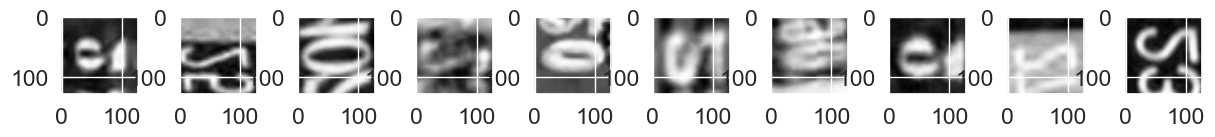

2025/02/09 07:38:25, line: 42     INFO | Client 3:


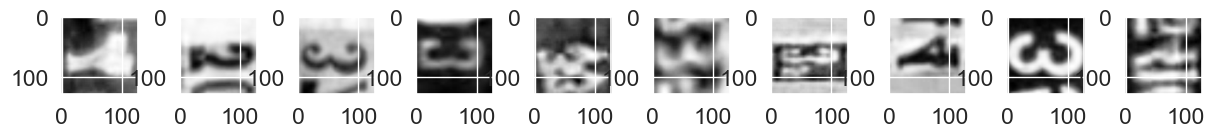

In [28]:
for client in [clients[0], clients[3]]:
    x, y = next(iter(client.train_loader))

    log.info("Client {}:".format(client.id))
    plt.figure(figsize=(15, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(x[i, 0].numpy().T, cmap="Greys")

    del x
    del y
    plt.show()

2025/02/09 07:38:38, line: 42     INFO | training done for client no 0 with loss of 0.49335732884131944
2025/02/09 07:38:43, line: 42     INFO | training done for client no 1 with loss of 0.7247602586393003
2025/02/09 07:38:49, line: 42     INFO | training done for client no 2 with loss of 0.6465023419549388
2025/02/09 07:39:01, line: 42     INFO | training done for client no 3 with loss of 0.5572415563085723
2025/02/09 07:39:10, line: 42     INFO | training done for client no 4 with loss of 0.7476733892547841
2025/02/09 07:39:20, line: 42     INFO | training done for client no 5 with loss of 0.76077575787254
2025/02/09 07:39:28, line: 42     INFO | training done for client no 6 with loss of 0.705985196125813
2025/02/09 07:39:36, line: 42     INFO | training done for client no 7 with loss of 0.6992180564919034
2025/02/09 07:39:45, line: 42     INFO | training done for client no 8 with loss of 0.842714362366255
2025/02/09 07:39:52, line: 42     INFO | training done for client no 9 with 

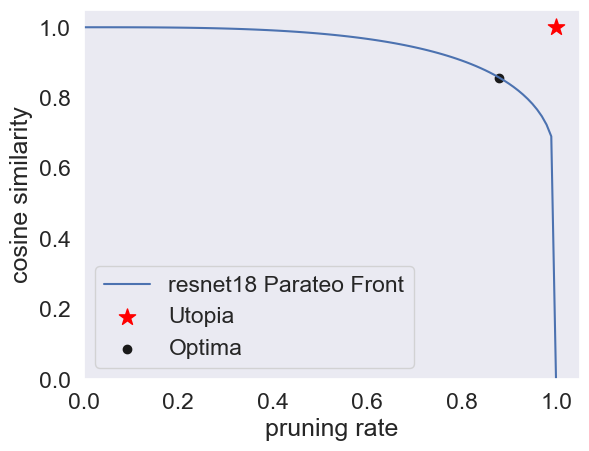

2025/02/09 07:39:57, line: 42     INFO | done calculating optimal sensitivity percentage with value of 12.0
2025/02/09 07:39:57, line: 42     INFO | Aggregating clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2025/02/09 07:39:57, line: 42     INFO | models to be aggregated count: 10
2025/02/09 07:39:57, line: 46  WARNING | testing done for client no 0 with accuracy of 0.0 and loss of 5.3778064805575365 [POOR]
2025/02/09 07:39:58, line: 46  WARNING | testing done for client no 1 with accuracy of 0.0 and loss of 5.386702514319831 [POOR]
2025/02/09 07:39:58, line: 46  WARNING | testing done for client no 2 with accuracy of 0.0 and loss of 5.329275440120097 [POOR]
2025/02/09 07:39:59, line: 46  WARNING | testing done for client no 3 with accuracy of 0.0 and loss of 3.6168910197951725 [POOR]
2025/02/09 07:39:59, line: 46  WARNING | testing done for client no 4 with accuracy of 0.4394736842105263 and loss of 2.221831770947105 [POOR]
2025/02/09 07:39:59, line: 46  WARNING | testing done for client no

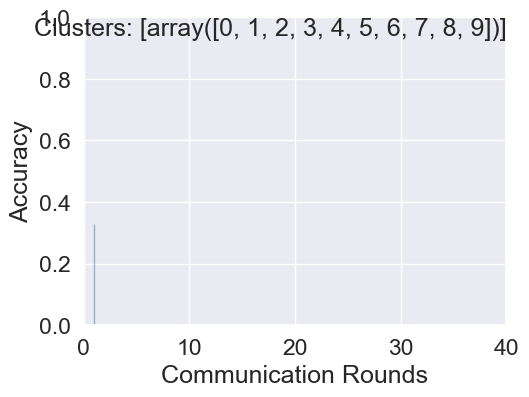

2025/02/09 07:40:13, line: 42     INFO | training done for client no 0 with loss of 1.3584053699786847
2025/02/09 07:40:28, line: 42     INFO | Gradients computed with 11172032 entries.
2025/02/09 07:40:33, line: 42     INFO | training done for client no 1 with loss of 1.2699379611898352
2025/02/09 07:40:40, line: 42     INFO | Gradients computed with 11172032 entries.
2025/02/09 07:40:46, line: 42     INFO | training done for client no 2 with loss of 1.2259514831727552
2025/02/09 07:40:53, line: 42     INFO | Gradients computed with 11172032 entries.
2025/02/09 07:41:06, line: 42     INFO | training done for client no 3 with loss of 2.648759323453146
2025/02/09 07:41:21, line: 42     INFO | Gradients computed with 11172032 entries.
2025/02/09 07:41:32, line: 42     INFO | training done for client no 4 with loss of 2.3801564294464734
2025/02/09 07:41:44, line: 42     INFO | Gradients computed with 11172032 entries.
2025/02/09 07:41:53, line: 42     INFO | training done for client no 5 

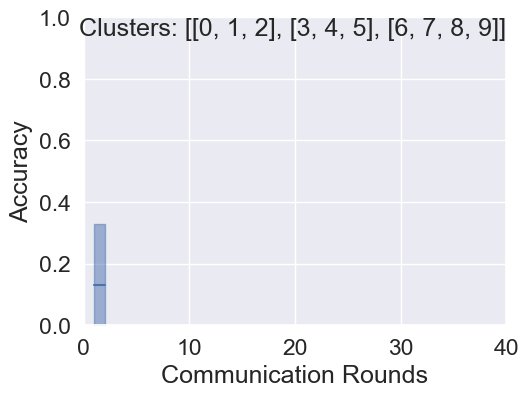

KeyboardInterrupt: 

In [29]:
cfl_stats = ExperimentLogger()
cluster_indices = [np.arange(len(clients)).astype("int")]
global_clients_clustered = []

for c_round in range(1, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"] + 1):
    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)

    """
        Checking clustering conditions
    """
    TRIGGER_CLUSTERING = c_round % SAFE_PFL_CONFIG["CLUSTERING_PERIOD"] == 0

    """
        Participating clients training loop
    """
    for index, client in enumerate(clients):
        client.compute_weight_update(
            be_ready_for_clustering=TRIGGER_CLUSTERING,
            epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"],
        )

    """
        Calculating the optimal sensitivity value (P)
    """
    if (
        c_round == 1
        and SAFE_PFL_CONFIG["DISTANCE_METRIC"]
        == distances_constants.DISTANCE_COORDINATE
        and SAFE_PFL_CONFIG["DYNAMIC_SENSITIVITY_PERCENTAGE"]
    ):
        SAFE_PFL_CONFIG.update(
            {
                "SENSITIVITY_PERCENTAGE": calculate_optimal_sensitivity_percentage(
                    clients[0].model
                )
            }
        )
        log.info(
            f'done calculating optimal sensitivity percentage with value of {SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"]}'
        )

    if TRIGGER_CLUSTERING:
        full_similarities = server.compute_pairwise_similarities(clients=clients)
        log.warn(f"Global clustering triggered {c_round}")

        clustering = server.cluster_clients(full_similarities)

        # cleaning the memory up
        del full_similarities
        for client in clients:
            client.gradients = {}

        cluster_indices = []
        for label in np.unique(clustering.labels_):
            cluster_indices.append(np.where(clustering.labels_ == label)[0].tolist())

        if SAFE_PFL_CONFIG["SAVE_BEFORE_AGGREGATION_MODELS"]:
            for client in clients:
                torch.save(
                    client.model.state_dict(),
                    MODEL_SAVING_PATH + f"client_{client.id}_model.pt",
                )

    client_clusters = []
    for cluster in cluster_indices:
        new_orientation = []
        for index in cluster:
            new_orientation.append(clients[index])
        client_clusters.append(new_orientation)
    global_clients_clustered = client_clusters 

    # acc_clients = [client.evaluate() for client in clients]

    server.aggregate_clusterwise(global_clients_clustered)
    
    acc_clients = [client.evaluate() for client in clients]

    cfl_stats.log(
        {
            "acc_clients": acc_clients,
            "rounds": c_round,
            "clusters": cluster_indices,
        }
    )

    display_train_stats(
        cfl_stats,
        SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"],
        output_clarence_status=False,
    )